In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Necessary Library

In [2]:
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling2D, LayerNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Get Dataset and Image 

In [3]:
REPORTS_CSV = '/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv'
PROJECTIONS_CSV = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
IMAGE_PATH = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/'
WEIGHT_PATH = '/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [4]:
reports_df = pd.read_csv(REPORTS_CSV)
reports_df = reports_df.dropna(subset=['findings'])
projections_df = pd.read_csv(PROJECTIONS_CSV)
merged_df = pd.merge(projections_df, reports_df[['uid', 'findings','impression']], on='uid', how='inner')

merged_df['image_path'] = IMAGE_PATH + merged_df['filename']

In [6]:
merged_df = merged_df[['uid','filename','findings','impression']]

# Image Feature

In [ ]:
# def chexnet(input_shape=(224, 224, 3), weights_path=None):
#     densenet = DenseNet121(weights=None, include_top=False)

#     if weights_path is not None:
#         densenet.load_weights(weights_path, by_name=True)
    
#     new_input = densenet.input
#     #Densenet output: (batchsize,7,7,1024)
#     #Global Average Pooling 2D Layer output: (batch size, 1024)
#     hidden_layers = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
   
#     model = tf.keras.Model(new_input, hidden_layers) 

#     return model 

def modified_chexnet(input_shape=(224, 224, 3), weights_path=None):
    # Base DenseNet121
    densenet = DenseNet121(weights=None, include_top=False)

    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)
    
    # Input
    new_input = densenet.input

    # DenseNet121 output: (batch_size, 7, 7, 1024)
    # Transformer compatibility: Reshape to (batch_size, num_patches, feature_dim)
    base_output = tf.keras.layers.Reshape((-1, 1024))(densenet.output)
    
    # Create the modified model
    model = tf.keras.Model(new_input, base_output)

    return model


In [ ]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def modified_resnet(input_shape=(224, 224, 3), weights_path=None,d_model=512):
    # Base ResNet50
    resnet = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    if weights_path is not None:
        resnet.load_weights(weights_path, by_name=True)
    
    # Input
    new_input = resnet.input

    # ResNet50 output: (batch_size, 7, 7, 2048)
    # Transformer compatibility: Reshape to (batch_size, num_patches, feature_dim)
    base_output = tf.keras.layers.Reshape((-1, 2048))(resnet.output)

    projected_output = tf.keras.layers.Dense(d_model)(base_output)
    
    # Create the modified model
    model = tf.keras.Model(new_input, projected_output)

    return model

In [ ]:
WEIGHT_RESNET50 = '/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf

def modified_efficientnet(input_shape=(224, 224, 3), weights_path=None, d_model=512):
    # Base EfficientNetB0
    efficientnet = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)

    if weights_path is not None:
        efficientnet.load_weights(weights_path, by_name=True)
    
    # Input
    new_input = efficientnet.input

    # EfficientNetB0 output: (batch_size, 7, 7, 1280)
    base_output = tf.keras.layers.Reshape((-1, 1280))(efficientnet.output)  # Shape: (batch_size, 49, 1280)
    
    # Project to d_model
    projected_output = tf.keras.layers.Dense(d_model)(base_output)  # Shape: (batch_size, 49, d_model)
    
    # Create the modified model
    model = tf.keras.Model(new_input, projected_output)

    return model

In [ ]:
WEIGHT_EN = '/kaggle/input/efficientnetb0-notop/efficientnetb0_notop.h5'

In [ ]:
image_feature_extractor = modified_efficientnet(weights_path=WEIGHT_EN)

In [ ]:
#Image will be on shape (224,224,3)
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

In [ ]:
image_files = [
    os.path.join(IMAGE_PATH, fname)
    for fname in os.listdir(IMAGE_PATH)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
]


In [ ]:
# Precompute and save image features
features_dict = {}
for img_path in image_files:
    try:
        # Preprocess image
        img_tensor = load_image(img_path)
        img_tensor = tf.expand_dims(img_tensor, 0)  # Add batch dimension (1, 224, 224, 3)

        # Extract features using your feature extractor
        img_features = image_feature_extractor(img_tensor)  
        features_dict[os.path.basename(img_path)] = img_features.numpy()  # Save as numpy array
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        
# Verify feature shapes
print("Sample Image Features:", list(features_dict.values())[0].shape)


In [ ]:
np.save("EfficientNet_image_features.npy", features_dict)

# Text Embedding and Image Feature

In [7]:
import pickle
# Load Image Features
features_dict2 = np.load('/kaggle/input/resnet-image-features-new/ResNet_image_features (2).npy',allow_pickle=True).item()
features_dict1 = np.load("/kaggle/input/chexnet-image-features/ChexNet_image_features.npy", allow_pickle=True).item()
features_dict3 = np.load("/kaggle/input/efficientnet-image-features/EfficientNet_image_features.npy", allow_pickle=True).item()

#Load Text Embedding from T5 model
text_embeddings_dict = pickle.load(open('/kaggle/input/new-text-embedding/new_text_embedding.pkl', 'rb'))



In [8]:
features_dict1['41_IM-2055-1001.dcm.png']

array([[[0.        , 0.00187063, 0.00148234, ..., 0.        ,
         0.91204613, 0.        ],
        [0.        , 0.00252725, 0.00184516, ..., 0.        ,
         0.90835017, 0.        ],
        [0.        , 0.00289858, 0.00315124, ..., 0.        ,
         0.9083529 , 0.        ],
        ...,
        [0.        , 0.00096848, 0.        , ..., 0.        ,
         0.90232825, 0.        ],
        [0.        , 0.00159534, 0.        , ..., 0.        ,
         0.87946993, 0.        ],
        [0.        , 0.00297003, 0.00113228, ..., 0.        ,
         0.8803017 , 0.        ]]], dtype=float32)

In [9]:
text_embeddings_dict[1].shape

(1, 57, 512)

# Target Output

In [10]:
import re
from collections import Counter

VOCAB_SIZE = 5000
findings = merged_df['findings'].dropna().values
# Tokenization function using basic Python and regex
def tokenize_text(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)  # Extract word tokens
    return tokens

# Add <start> and <end> tokens and tokenize each finding
tokenized_captions = [["<start>"] + tokenize_text(finding) + ["<end>"] for finding in findings]

# Create a word frequency counter to understand the vocabulary size
word_counter = Counter(token for caption in tokenized_captions for token in caption)

# Create a vocabulary of the most common words up to VOCAB_SIZE
vocab = [word for word, freq in word_counter.most_common(VOCAB_SIZE - 1)]  # Reserving one spot for <unk>
vocab = ["<pad>", "<unk>"] + vocab  # Adding special tokens

# Create word to index and index to word mappings
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Convert tokenized captions to sequences of indices
cap_seqs = [[word_to_index.get(token, word_to_index["<unk>"]) for token in caption] for caption in tokenized_captions]

# Display the first few tokenized sequences for verification
cap_seqs[:2]


[[7,
  2,
  55,
  27,
  9,
  41,
  19,
  4,
  21,
  6,
  23,
  15,
  5,
  3,
  25,
  84,
  15,
  5,
  3,
  20,
  26,
  15,
  4,
  3,
  14,
  11,
  47,
  10,
  16,
  15,
  5,
  3,
  63,
  11,
  13,
  8],
 [7,
  2,
  55,
  27,
  9,
  41,
  19,
  4,
  21,
  6,
  23,
  15,
  5,
  3,
  25,
  84,
  15,
  5,
  3,
  20,
  26,
  15,
  4,
  3,
  14,
  11,
  47,
  10,
  16,
  15,
  5,
  3,
  63,
  11,
  13,
  8]]

In [11]:
# Define the maximum sequence length based on the longest caption in the dataset
max_seq_len = max(len(seq) for seq in cap_seqs)

# Pad all sequences to have the same length
cap_seqs_padded = pad_sequences(cap_seqs, maxlen=max_seq_len, padding='post')

# Display the first few padded sequences for verification
cap_seqs_padded[:2]

array([[ 7,  2, 55, 27,  9, 41, 19,  4, 21,  6, 23, 15,  5,  3, 25, 84,
        15,  5,  3, 20, 26, 15,  4,  3, 14, 11, 47, 10, 16, 15,  5,  3,
        63, 11, 13,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  2, 55, 27,  9, 41, 19,  4, 21,  6, 23, 15,  5,  3, 25, 84,
        15,  5,  3, 20, 26, 15,  4,  3, 14, 11, 47, 10, 16, 15,  5,  3,
        63, 11, 13,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [12]:
uid_features1 = {}

for _, row in merged_df.iterrows():
    uid = row['uid']
    filename = row['filename']
    caption = cap_seqs_padded[_]
    
    # Fetch image features and text embedding based on uid
    img_feature = features_dict3.get(filename)
    text_embedding = text_embeddings_dict.get(uid)
    
    if img_feature is not None:
        if uid in uid_features1:
            uid_features1[uid]['img_features'].append(img_feature)
        else:
            
            uid_features1[uid] = {
                'img_features': [img_feature],
                'caption': caption
                  }

In [13]:
for uid, features in uid_features1.items():
    if len(features['img_features']) > 1:
        # Average the features of all images corresponding to the UID
        features['img_features'] = np.mean(features['img_features'], axis=0)
    else: 
        features['img_features'] = features['img_features'][0]

In [14]:
uid_features1[1]['img_features'].shape

(1, 49, 512)

In [5]:
# from transformers import TFT5EncoderModel

# # Load pre-trained T5 encoder
# t5_encoder = TFT5EncoderModel.from_pretrained("/kaggle/input/finetuned-t5/fine_tuned_t5_modelAgain")

# # Function to generate T5 embeddings
# def generate_t5_embeddings(tokenized_captions):
#     """
#     Generate T5 embeddings for a list of tokenized captions.

#     Args:
#     - tokenized_captions (list of lists): List of tokenized caption sequences.

#     Returns:
#     - np.array: Embeddings for each caption (shape: num_samples, seq_len, d_model).
#     """
#     tokenized_captions = tf.convert_to_tensor(tokenized_captions, dtype=tf.int32)  # Convert to Tensor
#     embeddings = t5_encoder(input_ids=tokenized_captions).last_hidden_state
#     return embeddings.numpy()  # Convert back to NumPy for dataset preparation


In [15]:
# Extract image features and captions from the dictionary
image_features_list = []
decoder_input_list = []
decoder_target_list = []

for uid, data in uid_features1.items():
    # Extract the image feature
    image_features = data['img_features']  # Shape: (1, 1024)
    
    # Tokenized caption
    caption = data['caption']
    
    # Split the caption into decoder input and target
    decoder_input = caption[:-1]  # Input sequence without the last token
    decoder_target = caption[1:]  # Target sequence without the first token
    
    # Append the data for training
    image_features_list.append(image_features[0])  # Flatten from (1, 1024) to (1024)
    decoder_input_list.append(decoder_input)
    decoder_target_list.append(decoder_target)
    
    
# Convert lists to NumPy arrays for easier processing
image_features_array = np.array(image_features_list)  # Shape: (num_samples, 1024)
decoder_input_array = np.array(decoder_input_list)    # Shape: (num_samples, max_seq_len-1)
decoder_target_array = np.array(decoder_target_list)  # Shape: (num_samples, max_seq_len-1)

# Pad sequences to ensure they have the same length for the decoder input and target
decoder_input_padded = tf.keras.preprocessing.sequence.pad_sequences(decoder_input_array, padding='post', maxlen=172)
decoder_target_padded = tf.keras.preprocessing.sequence.pad_sequences(decoder_target_array, padding='post', maxlen=172)

# Convert to TensorFlow tensors
image_features_tensor = tf.convert_to_tensor(image_features_array, dtype=tf.float32)  # Shape: (num_samples, 1024)
decoder_input_tensor = tf.convert_to_tensor(decoder_input_padded, dtype=tf.int32)     # Shape: (num_samples, 172)
decoder_target_tensor = tf.convert_to_tensor(decoder_target_padded, dtype=tf.int32)   # Shape: (num_samples, 172)

# Create a TensorFlow dataset for training
BATCH_SIZE = 16
dataset = tf.data.Dataset.from_tensor_slices(((image_features_tensor,decoder_input_tensor), decoder_target_tensor))
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

for (images, caption),targets in dataset.take(1):
    print('Image batch shape:', images.shape)
    print('Target batch shape:', targets.shape)

print("Dataset element structure:", dataset.element_spec)

Image batch shape: (16, 49, 512)
Target batch shape: (16, 172)
Dataset element structure: ((TensorSpec(shape=(None, 49, 512), dtype=tf.float32, name=None), TensorSpec(shape=(None, 172), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 172), dtype=tf.int32, name=None))


# Transformer Model

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np

# Positional Encoding function for Transformer
class PositionalEncoding(tf.keras.layers.Layer):
    # Initialization of the PositionalEncoding layer.
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position  # The number of positions (sequence length).
        self.d_model = d_model    # The dimensionality of the model (embedding size).

    # This method calculates the angle rates for each position and dimension.
    def get_angles(self, pos, i, d_model):
        # `angle_rates` determines how the positional encodings are distributed.
        # The formula used here is 1 / (10000 ^ (2 * (i // 2) / d_model)).
        # This helps create a unique encoding for each position at each dimension.
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        # Create a grid of position values and corresponding dimensions.
        # `np.arange(self.position)[:, np.newaxis]` generates an array of shape (position, 1),
        # and `np.arange(self.d_model)[np.newaxis, :]` generates an array of shape (1, d_model).
        # The result will be a matrix of shape (position, d_model).
        angle_rads = self.get_angles(np.arange(self.position)[:, np.newaxis], 
                                     np.arange(self.d_model)[np.newaxis, :],
                                     self.d_model)
        
        # Apply sin to even indices and cos to odd indices to create the final positional encoding.
        # This follows the original transformer paper's method for positional encoding.
        # Even dimensions (indices 0, 2, 4, ...) use sine, while odd dimensions (indices 1, 3, 5, ...) use cosine.
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sine to even indices.
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cosine to odd indices.

        # Add an extra dimension to the resulting positional encoding to match the shape of the input.
        pos_encoding = angle_rads[np.newaxis, ...]

        # Return the input tensor with the positional encoding added.
        # `inputs` are typically embeddings (shape: [batch_size, position, d_model]).
        # Positional encodings are added element-wise to `inputs` to give the final input for attention layers.
        return inputs + tf.cast(pos_encoding, tf.float32)

    
class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, vocab_size, rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Multi-head attention and feed-forward layers
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_model * 4, activation='relu'),
            Dense(d_model)
        ])

        # Layer normalization and dropout
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, x, context, mask=None):
        # Multi-head attention
        attn_output = self.mha(query=context, value=context, key=context, attention_mask=mask)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(context + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# Image Captioning Model with Transformer
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, units, vocab_size, num_heads, d_model, max_position_embeddings,**kwargs):
        super(ImageCaptioningModel, self).__init__(**kwargs)
        self.units = units
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.d_model = d_model
        self.max_position_embeddings = max_position_embeddings

        # Image feature processing
        self.img_fc = Dense(units, activation='relu')
        self.global_avg_pool = GlobalAveragePooling1D()
        self.text_embedding = Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(max_position_embeddings, units)
        self.decoder = TransformerDecoder(num_heads=num_heads, d_model=d_model, vocab_size=vocab_size)
        self.fc = Dense(vocab_size)

    def call(self, inputs):
    img_features, decoder_input_batch = inputs

    # # Apply global average pooling to the image batch to reduce spatial dimensions to a fixed-size vector
    # pooled_image_features = self.global_avg_pool(image_batch)
    
    # # Pass the pooled image features through a fully connected layer (img_fc) to transform the image features
    # img_features = self.img_fc(pooled_image_features)
    
    # Add an extra dimension to img_features to make it compatible with the transformer input
    img_features = tf.expand_dims(img_features, axis=1)  # Shape becomes (batch_size, 1, units)

    # Pass the decoder input (text) through the embedding layer to convert words into dense vectors
    text_embedding = self.text_embedding(decoder_input_batch)
    
    # Apply positional encoding to the text embeddings to add position information
    text_embedding = self.pos_encoding(text_embedding)

    # Concatenate the image features (img_features) with the text embeddings (text_embedding) along the sequence length axis
    # This combines the visual information with the textual sequence
    combined_features = tf.concat([img_features, text_embedding], axis=1)

    # Create a mask to ignore the padding tokens in the decoder input
    # A mask of '1' is placed where padding tokens (zeroes) are found in the 'decoder_input_batch'
    mask = tf.cast(tf.math.equal(decoder_input_batch, 0), dtype=tf.float32)
    
    # Prepend the mask with a '0' to ensure the image feature (at the start of the sequence) is not masked
    mask = tf.concat([tf.zeros((tf.shape(mask)[0], 1), dtype=tf.float32), mask], axis=1)
    
    # Reshape the mask to have a shape compatible with the transformer decoder (batch_size, 1, 1, sequence_length)
    mask = tf.reshape(mask, (tf.shape(mask)[0], 1, 1, tf.shape(mask)[1]))

    # Pass the text embeddings, combined features, and the mask to the transformer decoder
    decoder_output = self.decoder(text_embedding, combined_features, mask=mask)
    
    # Remove the image feature (the first token in the sequence) from the decoder output
    # We slice the output to keep the remaining tokens (skip the first token, which is the image feature)
    decoder_output = decoder_output[:, 1:, :]  # Shape becomes (batch_size, sequence_length, d_model)

    # Pass the decoder output through a fully connected layer (fc) to predict the next word in the caption sequence
    output = self.fc(decoder_output)  # Output shape becomes (batch_size, sequence_length, vocab_size)

    return output


    def get_config(self):
        config = super(ImageCaptioningModel, self).get_config()
        config.update({
            'units': self.units,
            'vocab_size': self.vocab_size,
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'max_position_embeddings': self.max_position_embeddings
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [13]:
from transformers import TFT5EncoderModel
import tensorflow as tf
from transformers import TFBertModel, AutoModel

t5_encoder = TFT5EncoderModel.from_pretrained("/kaggle/input/finetuned-t5/fine_tuned_t5_modelAgain")
# biobert_model = TFBertModel.from_pretrained("/kaggle/input/bio-clinicalbert/Bio_ClinicalBERT")

class ImageCaptioningModelWithPrecomputedEmbeddings(tf.keras.Model):
    def __init__(self, units, vocab_size, num_heads, d_model, max_position_embeddings, **kwargs):
        super(ImageCaptioningModelWithPrecomputedEmbeddings, self).__init__(**kwargs)
        self.units = units
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        self.d_model = d_model
        self.max_position_embeddings = max_position_embeddings

        # Image feature processing
        self.img_fc = Dense(units, activation='relu')
        self.global_avg_pool = GlobalAveragePooling1D()
        self.pos_encoding = PositionalEncoding(max_position_embeddings, self.units)
        self.decoder = TransformerDecoder(num_heads=num_heads, d_model=d_model, vocab_size=vocab_size)
        self.fc = Dense(vocab_size)

    def call(self, inputs):
        image_batch, decoder_input_embeddings = inputs
        
        # Process image features
        pooled_image_features = self.global_avg_pool(image_batch)
        img_features = self.img_fc(pooled_image_features)
        img_features = tf.expand_dims(img_features, axis=1)

        # Add positional encoding to precomputed text embeddings
        text_embedding = t5_encoder(input_ids=decoder_input_embeddings).last_hidden_state
        text_embedding = self.pos_encoding(text_embedding)
        
        # Combine image and text features
        combined_features = tf.concat([img_features, text_embedding], axis=1)

        # Create mask for padding
        mask = tf.cast(tf.math.equal(decoder_input_embeddings, 0), dtype=tf.float32)
        mask = tf.concat([tf.zeros((tf.shape(mask)[0], 1), dtype=tf.float32), mask], axis=1)
        mask = tf.reshape(mask, (tf.shape(mask)[0], 1, 1, tf.shape(mask)[1]))

        # Transformer decoder
        decoder_output = self.decoder(text_embedding, combined_features, mask=mask)
        decoder_output = decoder_output[:, 1:, :]
        output = self.fc(decoder_output)

        return output


    # def get_config(self):
    #     config = super(ImageCaptioningModelWithPrecomputedEmbeddings, self).get_config()
    #     config.update({
    #         'units': self.units,
    #         'vocab_size': self.vocab_size,
    #         'num_heads': self.num_heads,
    #         'd_model': self.d_model,
    #         'max_position_embeddings': self.max_position_embeddings
    #     })
    #     return config

    # @classmethod
    # def from_config(cls, config):
    #     return cls(**config)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5EncoderModel: ['decoder.block.2.layer.0.SelfAttention.q.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.2.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.2.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.2.DenseReluDense.wi.weight', 'decoder.block.3.layer.2.DenseReluDense.wi.weight', 'decoder.block.3.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.final_layer_norm.weight', 'decoder.block.5.layer.2.layer_norm.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.3.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block

In [17]:
# Define model parameters
units = 512
vocab_size = 10000
num_heads = 8
d_model = 512
max_position_embeddings=172

# Instantiate and compile the model
image_captioning_model = ImageCaptioningModel(units, vocab_size, num_heads, d_model,max_position_embeddings)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Set a fixed learning rate
image_captioning_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = image_captioning_model.fit(dataset, epochs=10, batch_size=16)

Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.7710 - loss: 2.8133
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 984s 5s/step - accuracy: 0.8213 - loss: 0.9656
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 1043s 5s/step - accuracy: 0.8487 - loss: 0.8257
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 989s 5s/step - accuracy: 0.8765 - loss: 0.6419
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 975s 5s/step - accuracy: 0.8854 - loss: 0.5650
Epoch 6/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 975s 5s/step - accuracy: 0.8903 - loss: 0.5252
Epoch 7/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 974s 5s/step - accuracy: 0.8936 - loss: 0.4953
Epoch 8/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 982s 5s/step - accuracy: 0.8941 - loss: 0.4860
Epoch 9/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 974s 5s/step - accuracy: 0.8966 - loss: 0.4645
Epoch 10/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 993s 5s/step - accuracy: 0.8984 - loss: 0.4512


In [18]:
image_captioning_model.save('chex_captioning_model_updated.keras')

In [17]:
# custom_objects = {
#     "ImageCaptioningModel": ImageCaptioningModel,
#     "PositionalEncoding": PositionalEncoding,
#     "TransformerDecoder": TransformerDecoder,
# }

In [44]:
# custom_objectst5 = {
#     "ImageCaptioningModelWithPrecomputedEmbeddings": ImageCaptioningModelWithPrecomputedEmbeddings,
#     "PositionalEncoding": PositionalEncoding,
#     "TransformerDecoder": TransformerDecoder,
# }

In [18]:
from tensorflow.keras.models import load_model

# Load the model with custom layers
efficientbase_captioning_model = load_model('/kaggle/input/efficient-net-image-captioning-model/efficient_net_image_captioning_model1.keras')


# Generating Caption 

In [19]:
# import tensorflow as tf
# import numpy as np

# def generate_caption_with_sampling(model, uid, uid_features, word_to_index, index_to_word, max_length=172, temperature=0.7):
#     # Define start and end tokens using word_to_index
#     start_token = word_to_index['<start>']
#     end_token = word_to_index['<end>']
    
#     # Initialize the input sequence with the start token
#     caption = [start_token]
    
#     # Retrieve image features from uid_features dictionary
#     if uid not in uid_features:
#         return 'This image has no findings'
        
    
#     image_features = uid_features[uid]['img_features']  # Shape: (1, 1024)

#     # Generate caption word-by-word
#     for i in range(max_length):
#         # Pad the caption so far to the maximum length required by the model
#         input_sequence = tf.keras.preprocessing.sequence.pad_sequences([caption], maxlen=max_length, padding='post')
        
#         # Predict the next word in the sequence
#         predictions = model.predict([image_features, input_sequence], verbose=0)
        
#         # Apply temperature scaling
#         predictions = predictions[0, len(caption)-1] / temperature
#         predictions = np.exp(predictions) / np.sum(np.exp(predictions))  # Softmax with temperature
        
#         # Sample the next word based on the adjusted probabilities
#         predicted_id = np.random.choice(len(predictions), p=predictions)
        
#         # Append the predicted word to the caption
#         caption.append(predicted_id)
        
#         # Stop if the end token is predicted
#         if predicted_id == end_token:
#             break
    
#     # Convert token IDs back to words, omitting the <start>, <end>, and <pad> tokens
   
#     caption_words = [index_to_word.get(i, '<unk>') for i in caption if i not in {start_token, end_token, word_to_index["<pad>"]}]
    
#     # Join words to form the final caption
#     final_caption = ' '.join(caption_words)
#     return final_caption

def generate_caption_with_sampling(model, uid, uid_features, word_to_index, index_to_word, max_length=172, temperature=0.7):
    # Define start and end tokens using word_to_index
    start_token = word_to_index['<start>']
    end_token = word_to_index['<end>']
    
    # Initialize the input sequence with the start token
    caption = [start_token]
    
    # Retrieve image features from uid_features dictionary
    if uid not in uid_features:
        return 'This image has no findings'
        
    image_features = uid_features[uid]['img_features']  # Shape: (1, 1024)

    # Generate caption word-by-word
    for i in range(max_length):
        # Pad the caption so far to the maximum length required by the model
        input_sequence = tf.keras.preprocessing.sequence.pad_sequences([caption], maxlen=max_length, padding='post')
        
        # Predict the next word in the sequence
        predictions = model.predict([image_features, input_sequence], verbose=0)
        
        # Sample the next word based on the adjusted probabilities
        predicted_id = np.random.choice(len(predictions), p=predictions)
        
        # Append the predicted word to the caption
        caption.append(predicted_id)
        
        # Stop if the end token is predicted
        if predicted_id == end_token:
            break
    
    # Convert token IDs back to words, omitting the <start>, <end>, and <pad> tokens
    caption_words = [index_to_word.get(i, '<unk>') for i in caption if i not in {start_token, end_token, word_to_index["<pad>"]}]
    
    # Join words to form the final caption
    final_caption = ' '.join(caption_words)
    return final_caption



In [20]:
def get_uid(filename):
    if filename is not None:
        # Filter projections_df for the specific filename and get the 'uid' column values
        uid_values = merged_df[merged_df['filename'] == filename]['uid'].values[0]
        
    return uid_values



In [19]:
merged_df['findings'][70]

'The cardiomediastinal silhouette is stable in appearance. No interval change in the diffuse increased bilateral pulmonary interstitial markings, greatest in the peripheral aspect of the left lung and left lung base. These opacities appear slightly increased as compared to prior examination. Mild left-sided volume loss redemonstrated, unchanged. No pneumothorax or pleural effusion. The thoracic spine appears intact.'

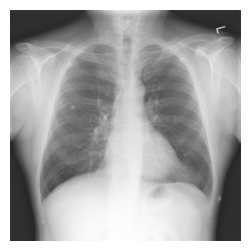

Generated Caption: left lung volumes noted aorta xxxx opacity no focal areas of the lungs are clear heart size with right upper lobe is no pneumothorax visualized osseous structures are unremarkable

Diagnose Report: The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is not enlarged. There has been apparent interval increase in low density convexity at the left cardiophrenic XXXX. Calcified granuloma is again seen in the right upper lobe. There is no consolidation, pleural effusion or pneumothorax.


In [24]:
import cv2
import matplotlib.pyplot as plt

filename = '9_IM-2407-1001.dcm.png'
uid = get_uid(filename)
caption = generate_caption_with_sampling(efficientbase_captioning_model, uid, uid_features1, word_to_index, index_to_word)
img_path = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/' + filename
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# Display the image with the generated caption
plt.figure(figsize=(3, 3))
plt.imshow(image)
plt.axis('off')
plt.show()

print("Generated Caption:", caption)
print( )
actual_caption = merged_df[merged_df['uid'] == uid]['findings'].iloc[0]
print("Diagnose Report:", actual_caption)


# Evaluate